# 지원동기 대신 써주는 프로그램

In [517]:
from bs4 import BeautifulSoup
from downloads import *
import requests
import time
import urllib
import os
from nltk.probability import FreqDist
from NLP import * 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import re
import matplotlib.font_manager as fm
import ngram
from konlpy.tag import Hannanum, Kkma, Komoran, Okt #, Mecab (Linux)
font_setting()

# Input

In [171]:
q = input("지원하시는 회사의 이름을 기재해주세요\t")
q2 = input("지원하는 회사의 직무를 기재해주세요\t")
try:
    p = int(input("몇 페이지까지 검색할까요?\t\t"))
except:
    p = 100
q3=input("공고에 직무에 대한 설명이 있다면 키워드 중심으로 같이 써주세요(없을 시 공란으로 두세요)\t")

지원하시는 회사의 이름을 기재해주세요	삼성생명
지원하는 회사의 직무를 기재해주세요	디지털
몇 페이지까지 검색할까요?		
공고에 직무에 대한 설명이 있다면 키워드 중심으로 같이 써주세요(없을 시 공란으로 두세요)	


In [518]:
number = re.compile("\d")

In [573]:
def cleaning_query(query):
    naver = BeautifulSoup(download("https://search.naver.com/search.naver?",params={"query":query}).text,"lxml")
    company_official_name = naver.select_one(".sp_company .main_title").text
    company_name = [_.text for _ in naver.select(".nsite dt a")][0]
    company_link = [_.text for _ in naver.select(".nsite dt a")][1].replace("www.","").replace(".com","")
    company_details = [_.text.strip() for _ in naver.select(".company_area .txt,.company_area .txt_info") if not number.search(_.text)]
    company_stock_name = company_details[0]
    company_subsidary = company_details[1].split(" ")[0]
    company_ceo = company_details[2]
    company_industry = company_details[3]
    query_list = [query, q2]
    query_list += [company_official_name,company_name,split_sub(company_official_name),
               split_sub(company_name),company_stock_name,company_subsidary]

    ub = re.compile("업")
    query_list.extend(ub.sub("",company_industry).split())
    for _ in range(2,len(q)):
        query_list += ngram.umjeol(query,_)
        query_list += ngram.umjeol(company_ceo,_)
    query_list=[_.lower() for _ in query_list]
    query_list = [_ for _ in unique(query_list) if _ != "" and "," not in _] 
    return query_list

In [558]:
q="교보생명"

In [522]:
company_friends

['삼성화재', '한화생명', '교보생명', '동양생명', '신한생명']

In [523]:
company_official_name,company_name

('삼성생명보험', '삼성생명')

In [524]:
print("{0}에 입사하게 된다면 최고의 {1} 전문가가 되도록 언제나 노력하겠습니다".format(company_official_name,q2))

삼성생명보험에 입사하게 된다면 최고의 디지털 전문가가 되도록 언제나 노력하겠습니다


# Crawling

In [525]:
def clean_title(title,query):
    for q in query:
        if q in title:
            title = title.replace(q,"")
    pattern = re.compile("\[.*\]")
    if pattern.search(title):
        title = pattern.sub("",title)
    return title

## keyword cleansing : 그룹사, 다른이름 빼기

In [526]:
def split_sub(name):
    pttn=re.compile("[A-z]+")
    if pttn.search(name):
        return pttn.search(name)[0],pttn.sub("",name)
    else:
        return ''

In [527]:
okt = Komoran()
q2_token = okt.pos(q)
query_list = [okt.pos(q)[0][0], okt.pos(q2)[0][0]]

In [529]:
company_official_name,company_link

('삼성생명보험', 'samsunglife')

In [530]:
query_list

['삼성생명', '디지털']

In [531]:
query_list += [company_official_name,company_name,split_sub(company_official_name),
               split_sub(company_name),company_stock_name,company_subsidary]

In [532]:
query_list = [_ for _ in unique(query_list) if _ != ""] 

In [533]:
query_list

['디지털', '삼성', '삼성생명', '삼성생명보험', '삼성생명보험(주)']

In [534]:
ub = re.compile("업")

In [535]:
query_list.extend(ub.sub("",company_industry).split())

In [536]:
for _ in range(2,len(q)):
    query_list += ngram.umjeol(q,_)
    query_list += ngram.umjeol(company_ceo,_)

In [358]:
query_list=[_.lower() for _ in query_list]

In [359]:
query_list=[_ for q in query_list for _ in q.split(" ")]

In [360]:
query_list

['디지털',
 '삼성',
 '삼성생명',
 '삼성생명보험',
 '삼성생명보험(주)',
 '생명',
 '보험',
 '삼성',
 '성생',
 '생명',
 '현성',
 '성철',
 '삼성생',
 '성생명',
 '현성철']

In [410]:
news_list=[]
for page in range(1,p+1):
    url=download("https://search.daum.net/search",params={"w":"news","q":q+" "+q2,"cluster":"y","p":str(page)})
    dom=BeautifulSoup(url.text,"lxml")
    news_list+=[clean_title(_.text,query_list) for _ in dom.select("article .wrap_tit.mg_tit a")]

In [412]:
df = cleansing(news_list)

In [362]:
pd.DataFrame(news_list).to_csv(str(p)+str(q)+".csv")

## find keyword  : preprocessing

In [363]:
find_keyword=[_.upper().strip() for _ in news_list if _.strip() != ""]

In [364]:
pattern=re.compile("^NN|(SL)")

In [397]:
freq=FreqDist([_ for keyword in find_keyword for _ in okt.pos(keyword) if _[0] not in query_list and pattern.search(_[1])])

In [398]:
freq

FreqDist({('로봇', 'NNP'): 116, ('전자', 'NNG'): 95, ('미술', 'NNG'): 84, ('대회', 'NNG'): 83, ('모바일', 'NNP'): 77, ('금융', 'NNG'): 75, ('확인', 'NNG'): 74, ('가입', 'NNG'): 74, ('활동', 'NNG'): 71, ('봉사', 'NNG'): 69, ...})

In [368]:
freq=FreqDist([_[0] for keyword in find_keyword for _ in okt.pos(keyword) if _[0] not in query_list and len(_[0])>1 and pattern.search(_[1])])

# 시각화

In [369]:
plt.rcParams.update({'font.size': 10, 'figure.figsize':(14,12)})

In [269]:
# !pip install wordcloud

In [270]:
from wordcloud import WordCloud

In [271]:
for_cld = FreqDist([_[0] for keyword in find_keyword for _ in okt.pos(keyword) if pattern.search(_[1]) and _[0] not in query_list and len(_[0])>1])
# for_cld = FreqDist([_[0] for _ in freq])

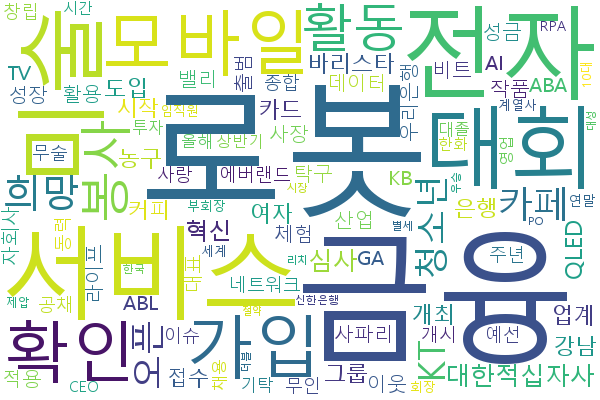

In [272]:
cld = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",width=600,height=400,background_color='white',max_words=100)
cld.generate_from_frequencies(freq).to_image()

## 동종회사

In [565]:
friends_news_list = []
for comp in company_friends: 
    news = []
    for page in range(1,p+1):
        url = download("https://search.daum.net/search",params={"w":"news","q":comp+" "+q2,"cluster":"y","p":str(page)})
        dom = BeautifulSoup(url.text,"lxml")
        news += [clean_title(_.text,query_list) for _ in dom.select("article .wrap_tit.mg_tit a")]
    friends_news_list += [news]

In [566]:
friends_news_list 

[['한화, 금융 인력 양성 위해 스마트연수시스템 구축',
  '한화, 시대 발맞춰 종이 없는 연수원 개원',
  "여승주 한화 사장, ' ' 승부수…'아마존웹서비스' 도...",
  "한화, 콘텐츠 '크리에이터' 육성한다",
  '‘한화 3세’ 김동원, 한화 해외사업 첫 성적 합격점',
  '‘전략통’ 여승주 사장, 한화  혁신 진두지휘',
  "여승주 한화 사장, ' 금융' 광폭 행보",
  "한화. '라이프 파크 스마트연수시스템' 오픈",
  "한화, 연수원에 '종이' 없앴다..스마트연수시스템 구축",
  '" 완비" 한화, 신설 연수원 \'라이프 파크\' 개원',
  '한화, 세계 어린이 바둑대회 개최..24일까지 접수',
  "고려대의료원-한화 ' 헬스케어' 협약",
  "한화, 태플릿PC 하나로 교육진행 '한화 라이프 파크' 연수...",
  '한화, 세계어린이 국수전 개최',
  "한화, 경기 용인에 연수원 '라이프파크' 오픈",
  '한화,  혁신에 ‘박차’',
  '한화, 세계어린이 국수전 예선 접수.."10000:1 경쟁률을 뚫어라"',
  '한화 차남규 부회장, 스마트연수시스템 구축으로 최정예 금융전...',
  '연수원서 종이 없앤 한화...태블릿PC로 교육',
  '한화, 신설 연수원에 ‘스마트 연수시스템’ 구축',
  "여승주 한화 사장, '금융' 글로벌네트워크 시동",
  "한화,  금융플랫폼 '토스'서 미니 판매",
  "차남규·여승주 이끄는 한화, '생보 2위' 지위 '먹구름'",
  '한화, 스마트 인프라 기반 스마트연수시스템 구축',
  "한화, 용인에 '라이프 파크' 연수원 개원…모든 교육과정 화",
  '한화 드림플러스-코리아스타트업포럼, 생태계 조성위해 맞손',
  "여승주 한화 대표, 덧셈경영으로 '차남' 지원사격",
  ' 차남규 한화 부회장, 고객중심 미래먹거리 찾...',
  '10년 이상 우수한 콜센터 서비스 품질 유지하는 비결은',
  '한화, 속초·고성 등 산불피해 지원 실시',
  "한화 드림플러스, 제2의

In [567]:
def cleansing(list_1d, *query):
    query_list = cleaning_query(query)
    find_keyword = [_.upper().strip() for _ in list_1d  if _.strip() != ""]
    freq = FreqDist([_ for keyword in find_keyword for _ in okt.pos(keyword) if _[0] not in query_list and pattern.search(_[1])])
    freq = FreqDist([_[0] for keyword in find_keyword for _ in okt.pos(keyword) 
                           if _[0] not in query_list and len(_[0])>1 and pattern.search(_[1])])
    return freq

In [568]:
zipper = list(zip([q]+company_friends,[df] + friends_news_list))

In [580]:
freq_list = []
for name, news in zipper:
    print(name, cleaning_query(name))
    freq_list.append(cleansing(news, cleaning_query(news)))

교보생명 [' 윤', ' 윤열', '교보', '교보생', '교보생명', '교보생명보험', '교보생명보험(주)', '디지털', '보생', '보생명', '생명', '신창', '신창재', '열현', '윤열', '윤열현', '창재']


ConnectionError: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')",))

In [575]:
def lfd():
    return defaultdict(float)

def ld():
    return defaultdict(int)

In [576]:
from math import log2

In [577]:
tf = defaultdict(lfd)
df = defaultdict(int)
N = len(freq_list2)
maxtf = defaultdict(int)
i = 0 
for document in freq_list2:
    maxtf[i] = max(document.values())
    for term, freq in document.items():
        tf[i][term] = (freq) / maxtf[i] 
        df[term] += 1
    i += 1
idf = {term:(1+log2(N/freq)) for term, freq in df.items()}

AttributeError: 'list' object has no attribute 'values'

In [578]:
tfidf = defaultdict(ld)
i = 0 
for document in freq_list2:
    for term, freq in document.items():
        tfidf[i][term] = tf[i][term] * idf[term]
    i += 1

AttributeError: 'list' object has no attribute 'items'

In [491]:
tfidf.keys()

dict_keys([0, 1, 2, 3, 4, 5])

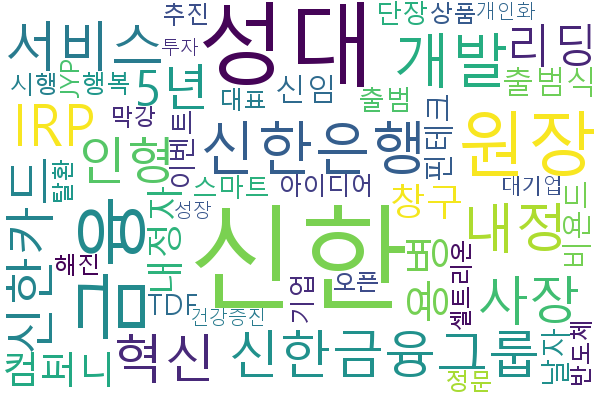

In [492]:
cld = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",width=600,height=400,background_color='white',max_words=50)
cld.generate_from_frequencies(tfidf[5]).to_image()

In [284]:
freq

FreqDist({'로봇': 116, '금융': 108, '서비스': 106, '전자': 103, '미술': 86, '대회': 83, '모바일': 77, '가입': 74, '확인': 74, '활동': 71, ...})

In [285]:
friends_freq

FreqDist({('화재', 'NNP'): 57, ('사', 'NNG'): 14, ('사장', 'NNG'): 10, ('위', 'NNB'): 9, ('원', 'NNB'): 8, ('금융', 'NNG'): 8, ('년', 'NNB'): 7, ('KB', 'SL'): 7, ('대상', 'NNP'): 6, ('씨', 'NNB'): 6, ...})